In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from keras.layers.advanced_activations import LeakyReLU, PReLU

from sklearn.model_selection import train_test_split 
from sklearn import metrics

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import regularizers
from keras.layers import Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [61]:
data = pd.read_csv('ks-projects-201801.csv')

In [62]:
# only use a subset of our whole dataset
length = len(data['goal'])
subset = length - 20000 # if we only want 20,000 rows

data = data.iloc[0:length-subset]

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
ID                  20000 non-null int64
name                20000 non-null object
category            20000 non-null object
main_category       20000 non-null object
currency            20000 non-null object
deadline            20000 non-null object
goal                20000 non-null float64
launched            20000 non-null object
pledged             20000 non-null float64
state               20000 non-null object
backers             20000 non-null int64
country             20000 non-null object
usd pledged         19784 non-null float64
usd_pledged_real    20000 non-null float64
usd_goal_real       20000 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 2.3+ MB


In [64]:
# number of days between launch data and deadline
def duration_of_project():
    duration = []
    
    for launch, deadline in zip(data['launched'], data['deadline']):
        
        launch = (launch.split())[0]
        launchT = [x.strip() for x in launch.split('-')]
        deadlineT = [x.strip() for x in deadline.split('-')]
    
        year_diff = (int(deadlineT[0]) - int(launchT[0]))*365
        month_diff = (int(deadlineT[1]) - int(launchT[1]))*30
        day_diff = int(deadlineT[2]) - int(launchT[2])
    
        days_offset = year_diff + month_diff + day_diff
        duration.append(days_offset)
        
    data['duration'] = duration

In [65]:
duration_of_project()

In [66]:
#getting unique categories in a list
cat = []
for i in data['category']:
    if i not in cat:
        cat.append(i)
#creating the unique categories successful mean
print(len(cat))
BackerMean = [0] * (len(cat) + 1)
GoalMean = [0] * (len(cat) + 1)

counter = 0
for i in cat:
    count = 0
    total = 0
    for j in data['category']:
        if j==cat[counter]:
            if data['state'][count] == 'successful':
                BackerMean[counter] += data['backers'][count]
                GoalMean[counter] += data['goal'][count]
                total = total + 1
        count = count + 1
    if BackerMean[counter]!= 0:
        BackerMean[counter] = BackerMean[counter]/total
        GoalMean[counter] = GoalMean[counter]/total
    BackerMean[counter] = round(BackerMean[counter])
    GoalMean[counter] = round(GoalMean[counter])
    counter = counter + 1

157


In [67]:
#Creates a Column stating a binary state on whether or not the project had reached the mean
#of backers in its prospective category
length = len(data['category'])
BackerBinary = [0] * length
CategoryMean = [0] * length
GoalBinary = [0] * length
counter = 0
for i in cat:
    count = 0
    for j in data['category']:
        if j == i:
            BackerBinary[count] = data['backers'][count] - BackerMean[counter]
            GoalBinary[count] = data['goal'][count] - GoalMean[counter]
            CategoryMean[count] = BackerMean[counter]
            if BackerBinary[count] < 0:
                BackerBinary[count] = 0
            else:
                BackerBinary[count] = 1
            if GoalBinary[count] > 0:
              GoalBinary[count] = 0
            else:
              GoalBinary[count] = 1
        count = count+1
    counter = counter + 1

In [68]:
data['GoalBinary'] = GoalBinary
data['state'].replace(['canceled'], ['failed'], inplace=True)
data['state'].replace(['failed', 'successful'], [-1, 1], inplace=True)

In [69]:
data['state_binary'] = data['state']
data['state_binary'].replace([-1, 1], [0, 1], inplace=True)

In [70]:
slim_data = data.copy()
indexNames = slim_data[ (slim_data['state_binary'] != 1) & (slim_data['state_binary'] != 0) ].index
slim_data.drop(indexNames , inplace=True)

In [71]:
# find length of name
name_length = []
for name in slim_data['name']:
    try:
        name_length.append(len(name))
    except:
        name_length.append(0)
slim_data['name_len'] = name_length

In [72]:
# scale down data columns
sc = MinMaxScaler()

slim_data['fit_goal'] = sc.fit_transform(slim_data[['goal']])
slim_data['fit_name_len'] = sc.fit_transform(slim_data[['name_len']])
slim_data['fit_duration'] = sc.fit_transform(slim_data[['duration']])

In [73]:
training=pd.get_dummies(slim_data, columns=["main_category"])
training=pd.get_dummies(training, columns=["category"])
training=pd.get_dummies(training, columns=["country"])
training=pd.get_dummies(training, columns=["currency"])

y = training['state_binary']
X = training.loc[:, 'fit_goal':]
X['GoalBinary'] = slim_data['GoalBinary']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [74]:
# build DNN

model = Sequential()

# input layer
model.add(Dense(200, activation='linear', input_dim = 213))
model.add(LeakyReLU(alpha=.001))
model.add(Dropout(0.5))

# second layer
model.add(Dense(100, activation='linear'))
model.add(LeakyReLU(alpha=.001))
model.add(Dropout(0.5))


# third layer
model.add(Dense(100, activation='linear'))
model.add(LeakyReLU(alpha=.001))
model.add(Dropout(0.5))


# fourth layer
model.add(Dense(150, activation='linear'))
model.add(LeakyReLU(alpha=.001))
model.add(Dropout(0.5))


# fith layer
model.add(Dense(100, activation='linear'))
model.add(LeakyReLU(alpha=.001))
model.add(Dropout(0.5))

# output layer
model.add(Dense(1, activation='sigmoid'))

# compile the model using rmsprop opt and mse loss
model.compile(optimizer = 'adam',  
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Train the model, iterating on the data in batches of 32 samples
history = model.fit(X_train, y_train, 
                    validation_split = 0.33, 
                    epochs = 50,
                    batch_size = 25)

# Evaluate the model's performance
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Training set accuracy:', train_acc)
print('Test set accuracy:', test_acc)

Train on 10478 samples, validate on 5161 samples
Epoch 1/50
10478/10478 [==============================] - 4s 408us/step - loss: 0.6414 - acc: 0.6358 - val_loss: 0.6186 - val_acc: 0.6727
Epoch 2/50
10478/10478 [==============================] - 3s 249us/step - loss: 0.6172 - acc: 0.6543 - val_loss: 0.6115 - val_acc: 0.6737
Epoch 3/50
10478/10478 [==============================] - 3s 248us/step - loss: 0.6109 - acc: 0.6709 - val_loss: 0.6164 - val_acc: 0.6663
Epoch 4/50
10478/10478 [==============================] - 3s 246us/step - loss: 0.6013 - acc: 0.6792 - val_loss: 0.6204 - val_acc: 0.6640
Epoch 5/50
10478/10478 [==============================] - 3s 280us/step - loss: 0.5943 - acc: 0.6839 - val_loss: 0.6073 - val_acc: 0.6720
Epoch 6/50
10478/10478 [==============================] - 3s 275us/step - loss: 0.5931 - acc: 0.6871 - val_loss: 0.6108 - val_acc: 0.6700
Epoch 7/50
10478/10478 [==============================] - 3s 270us/step - loss: 0.5908 - acc: 0.6855 - val_loss: 0.6060 - v

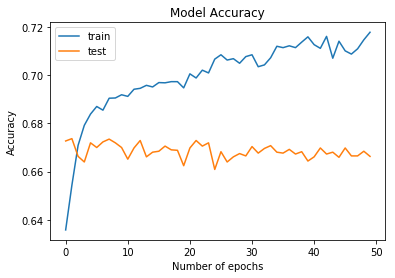

In [75]:
# The history of our accuracy during training.
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

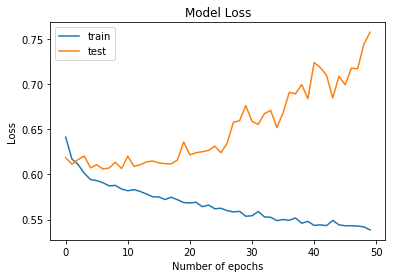

In [76]:
# The history of our cross-entropy loss during training.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [77]:
predictions = model.predict(X_test)
y_pred = []
neg = pos = 0
for pred in predictions:
    if pred < 0.5:
        neg += 1
        y_pred.append(0.0)
    else:
        pos += 1
        y_pred.append(1.0)
print("pos:", pos, " | neg:", neg)
print(len(X_test))

pos: 1092  | neg: 2818
3910


In [78]:
y_true = []
for val in y_test:
    y_true.append(val)
matrix = confusion_matrix(y_true, y_pred)
print(matrix)

[[1984  487]
 [ 834  605]]
